In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

from __future__ import division
from __future__ import print_function

import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc,numbers

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl


In [2]:
import Hawkes as hk

para = {"mu":0.1, "alpha":0.5, "beta":10.0}
itv = [0,1000000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para).set_itv(itv)
T = h1.simulate()
print(len(T))

h2 = hk.estimator().set_kernel('exp').set_baseline('const').set_itv(itv)
h2.fit(T)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T)

200464
mu     0    0.099736
alpha  0    0.502476
beta   0    9.979893
dtype: float64

191 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
import Hawkes as hk

para = {"mu":0.1, "alpha":[0.25,0.25], "beta":[1.0,20.0]}
itv = [0,1000000]

h1 = hk.simulator().set_kernel('exp',num_exp=2).set_baseline('const').set_parameter(para).set_itv(itv)
T = h1.simulate()
print(len(T))

h2 = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const').set_itv(itv)
h2.fit(T)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T)

199587
mu     0     0.100053
alpha  0     0.250941
       1     0.247758
beta   0     1.008104
       1    20.377654
dtype: float64

481 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
import Hawkes as hk

para = {"mu":0.1, "k":0.5,"p":2.0,"c":1.0}
itv = [0,1000000]

h1 = hk.simulator().set_kernel('pow').set_baseline('const').set_parameter(para).set_itv(itv)
T = h1.simulate()
print(len(T))

h2 = hk.estimator().set_kernel('pow').set_baseline('const').set_itv(itv)
h2.fit(T)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T)

200202
mu  0    0.099689
k   0    0.508271
p   0    2.006378
c   0    1.005910
dtype: float64

43.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1229
mu     0    11.186766
       1    17.617782
       2    15.199279
       3     3.188249
       4     0.150882
       5     9.631798
alpha  0     0.242348
beta   0     4.588091
dtype: float64
mu     0     5.670814
       1    -1.577507
       2     7.169495
       3    -1.825675
       4    -1.152617
       5    15.090874
alpha  0     0.306476
beta   0     3.500908
dtype: float64


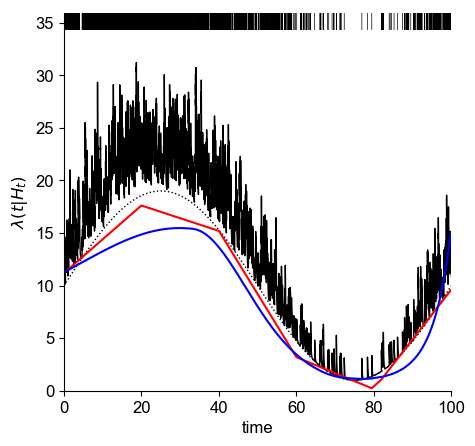

In [10]:
import Hawkes as hk

para = {"alpha":0.2,"beta":10.0}
mu_t = lambda x: 10.0 + 9.0*np.sin(2*np.pi*x/100)
itv = [0,100]
h1 = hk.simulator().set_kernel("exp").set_baseline('custom',l_custom=mu_t).set_parameter(para).set_itv(itv)
T = h1.simulate()
print(len(T))

# piecewise lienar model
h2 = hk.estimator().set_kernel("exp").set_baseline('plinear',num_basis=6).set_itv(itv)
h2.fit(T)
print(h2.para)

# log-linear model
h3 = hk.estimator().set_kernel("exp").set_baseline('loglinear',num_basis=6).set_itv(itv)
h3.fit(T)
print(h3.para)

h1.plot_l()
plt.plot(T,h2.l_baseline(T),"r-")
plt.plot(T,h3.l_baseline(T),"b-")
pass

1281
mu     0    673.265060
alpha  0      0.474464
beta   0      9.952664
dtype: float64


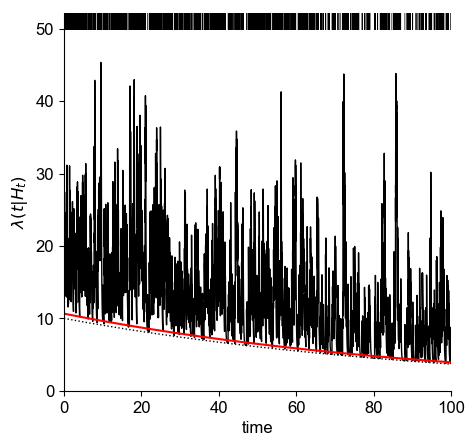

In [11]:
import Hawkes as hk

para = {"alpha":0.5,"beta":10.0}
mu_t = lambda x: 10.0*np.exp(-0.01*x)
mu_ref = lambda x: 0.01*np.exp(-0.01*x) /( 1 - np.exp(-1.0) )
itv = [0,100]

h1 = hk.simulator().set_kernel("exp").set_baseline('custom',l_custom=mu_t).set_parameter(para).set_itv(itv)
T = h1.simulate()
print(len(T))

h2 = hk.estimator().set_kernel("exp").set_baseline('prop',l_prop=mu_ref).set_itv(itv)
h2.fit(T)
print(h2.para)

h1.plot_l()
plt.plot(T,h2.l_baseline(T),"r-")
pass